# Valid Parentheses

Given a string s containing just the characters `(`, `)`, `{`, `}`, `[` and `]`, determine if the input string is valid.

An input string is valid if:

Open brackets must be closed by the same type of brackets.
Open brackets must be closed in the correct order.
Every close bracket has a corresponding open bracket of the same type.
 

**Example 1:**

Input: s = "()"
Output: true


**Example 2:**

Input: s = "()[]{}"
Output: true


**Example 3:**

Input: s = "(]"
Output: false
 

**Constraints:**

s consists of parentheses only '()[]{}'.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras.metrics as metrics

np.random.seed(42)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

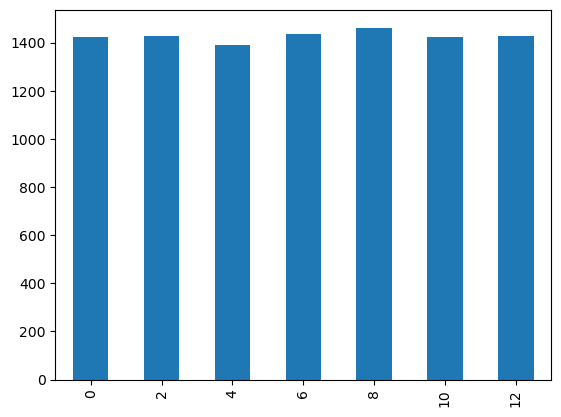

In [3]:
MAX_LENGTH_STRING = 8

VALID_CHARACTERS = [
    "(",
    ")",
    "[",
    "]",
    "{",
    "}",
]

MATCH = {
    ")": "(",
    "]": "[",
    "}": "{",
}


def is_valid(string: str) -> bool:
    match = MATCH

    stack = []
    for char in string:
        # opening
        if char in match.values():
            stack.append(char)

        # closing
        else:
            if not stack:
                return False

            item = stack.pop()
            if item != match[char]:
                return False

    return False if stack else True


def generate_even_number(min_value, max_value):
    number = np.random.randint(min_value // 2, max_value // 2 + 1)
    even_number = number * 2
    return even_number


# It generates the even numbers uniformly distributed, including the min and max values.
df = pd.DataFrame()
df["trials"] = [generate_even_number(0, 12) for _ in range(10_000)]
df["trials"].value_counts().sort_index().plot(kind="bar")
plt.show()

In [4]:
def generate_fixed_length_data_point(length) -> tuple:
    even_number = generate_even_number(length, length)
    string = "".join(
        np.random.choice(
            VALID_CHARACTERS,
            size=even_number,
            replace=True,
        )
    )
    return string, is_valid(string)


def generate_random_data_point(min_length, max_length) -> tuple:
    even_number = generate_even_number(min_length, max_length)
    return generate_fixed_length_data_point(even_number)


def generate_data_positive(
    num_samples,
    min_length=4,
    max_length=MAX_LENGTH_STRING,
) -> pd.DataFrame:
    """Generate the data points which are valid parentheses."""
    data = []
    while len(data) < num_samples:
        string, is_valid = generate_random_data_point(min_length, max_length)
        if is_valid:
            data.append([string, is_valid])

    df = pd.DataFrame(data, columns=["string", "is_valid"])
    return df


def generate_data_negative(
    num_samples,
    min_length=4,
    max_length=MAX_LENGTH_STRING,
) -> pd.DataFrame:
    """Generate the data points which are not valid parentheses."""
    data = []
    while len(data) < num_samples:
        string, is_valid = generate_random_data_point(min_length, max_length)
        if not is_valid:
            data.append([string, is_valid])

    df = pd.DataFrame(data, columns=["string", "is_valid"])
    return df


display(generate_data_positive(5))
display(generate_data_negative(5))

,string,is_valid
0,{}(),True
1,{()},True
2,{()},True
3,{()},True
4,(()),True


,string,is_valid
0,]{{[[(,False
1,[(}([{[],False
2,]]})]{}),False
3,][([[),False
4,}}){{(,False


This is good, but our positive data will probably be containing shorter strings, as it's more probable for the shorter string to be valid.

In [5]:
def get_even_lengths(num_samples, min_length, max_length):
    """
    Get evenly distributed lengths for given number of samples.
    E.g., num_samples=100, min_length=4, max_length=12, that means we will have 5 even numbers, and each will have 20 samples.
    """
    even_numbers = np.arange(min_length, max_length + 1, 2)
    even_numbers = np.repeat(even_numbers, num_samples // len(even_numbers))
    if len(even_numbers) < num_samples:
        print(
            f"Warning: We have {len(even_numbers)} data points instead of {num_samples} due to uneven distribution."
        )
    return even_numbers


display(pd.DataFrame(get_even_lengths(100, 4, 12)).value_counts())
display(pd.DataFrame(get_even_lengths(100, 4, 16)).value_counts())

4     20
6     20
8     20
10    20
12    20
dtype: int64

4     14
6     14
8     14
10    14
12    14
14    14
16    14
dtype: int64

In [6]:
get_even_lengths(10, 4, 12)

array([ 4,  4,  6,  6,  8,  8, 10, 10, 12, 12])

In [7]:
def generate_training_data(
    num_samples,
    min_length,
    max_string,
):
    num_positive_samples = num_samples // 2
    num_negative_samples = num_samples // 2

    even_lengths = get_even_lengths(
        num_positive_samples,  # or num_negative_samples
        min_length,
        max_string,
    )

    # Generate positive data
    positive_dataframes = []
    pbar = tqdm(total=len(even_lengths), desc="Generating positive data")
    for length in even_lengths:
        df = generate_data_positive(1, length, length)
        positive_dataframes.append(df)
        pbar.update(1)

    pbar.close()
    positive_data = pd.concat(positive_dataframes, ignore_index=True)

    # Generate negative data
    negative_dataframes = []
    pbar = tqdm(total=len(even_lengths), desc="Generating negative data")
    for length in even_lengths:
        df = generate_data_negative(1, length, length)
        negative_dataframes.append(df)
        pbar.update(1)

    pbar.close()
    negative_data = pd.concat(negative_dataframes, ignore_index=True)

    # Combine positive and negative data
    training_data = pd.concat([positive_data, negative_data], ignore_index=True)

    return training_data

In [8]:
generate_training_data(
    num_samples=10,
    min_length=4,
    max_string=12,
)

Generating positive data:   0%|          | 0/5 [00:00<?, ?it/s]

Generating negative data:   0%|          | 0/5 [00:00<?, ?it/s]

,string,is_valid
0,[][],True
1,()()(),True
2,([])()(),True
3,{({})()}(),True
4,[{}{}(({}))],True
5,[}{},False
6,({{({},False
7,)[){)]{],False
8,})}([(]}(],False
9,([{[)})([){(,False


Perfect :)

In [9]:
# Encode the parentheses strings into integers
def encode(string, max_length) -> np.ndarray:
    """Encode the parentheses strings into a vector of integers."""
    encoded = np.zeros(max_length, dtype=int)
    for i, char in enumerate(string):
        encoded[i] = VALID_CHARACTERS.index(char) + 1

    return encoded


print(encode("[([{}])]", max_length=MAX_LENGTH_STRING))
print(encode("(())", max_length=MAX_LENGTH_STRING))

[3 1 3 5 6 4 2 4]
[1 1 2 2 0 0 0 0]


In [10]:
def decode(encoded_string) -> str:
    """Decode the integers into parentheses strings."""
    string = ""
    for i in encoded_string:
        if i == 0:
            break
        string += VALID_CHARACTERS[i - 1]

    return string


print(decode([3, 1, 3, 5, 6, 4, 2, 4]))
print(decode([1, 1, 2, 2, 0, 0, 0, 0]))

[([{}])]
(())


Let us know create our training data.

In [11]:
n_samples = 10_000
min_length = 4
max_length = MAX_LENGTH_STRING
training_data = generate_training_data(n_samples, min_length, max_length)

Generating positive data:   0%|          | 0/4998 [00:00<?, ?it/s]

Generating negative data:   0%|          | 0/4998 [00:00<?, ?it/s]

In [12]:
# Save the generated training data
training_data.to_csv(f"./Valid_Parentheses/training_data_max_length_{MAX_LENGTH_STRING}.csv", index=False)

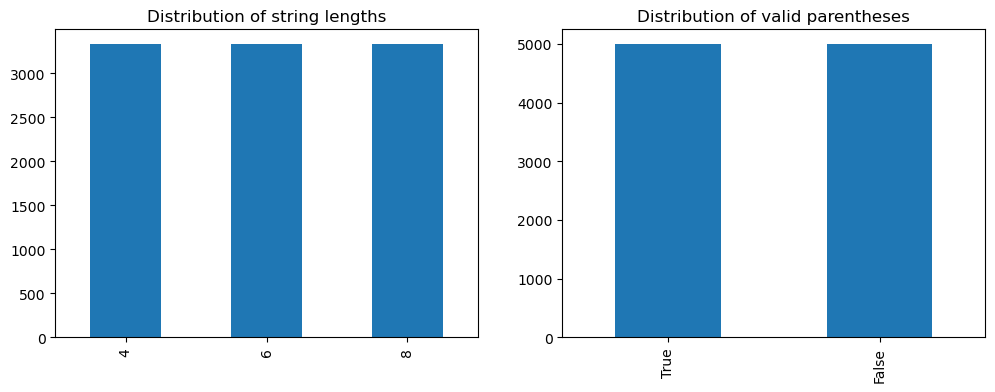

,string,is_valid
0,()[],True
1,(){},True
2,{[]},True
3,{}[],True
4,()[],True


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
training_data["string"].apply(len).value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Distribution of string lengths")

training_data["is_valid"].value_counts().plot(kind="bar", ax=axes[1])
axes[1].set_title("Distribution of valid parentheses")

plt.show()
display(training_data.head())

Train test split randomly.

In [14]:
X = np.array(
    [encode(string, MAX_LENGTH_STRING) for string in training_data["string"].values]
)
y = training_data["is_valid"].values.astype(int)
X[:5], y[:5]

(array([[1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 5, 6, 0, 0, 0, 0],
        [5, 3, 4, 6, 0, 0, 0, 0],
        [5, 6, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0]]),
 array([1, 1, 1, 1, 1]))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7497, 8) (2499, 8) (7497,) (2499,)


In [16]:
X_train

array([[5, 3, 5, ..., 4, 4, 6],
       [3, 5, 6, ..., 4, 3, 4],
       [6, 3, 3, ..., 1, 5, 6],
       ...,
       [1, 4, 5, ..., 0, 0, 0],
       [5, 6, 5, ..., 0, 0, 0],
       [4, 1, 1, ..., 3, 0, 0]])

Model creation

In [17]:
learning_rate = 0.001

model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim=256,
            output_dim=64,
            input_length=MAX_LENGTH_STRING,
        ),
        # # kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.LSTM(256, return_sequences=True),
        # tf.keras.layers.Dropout(0.25),  # Adding dropout
        tf.keras.layers.LSTM(128),
        # , kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(64, activation="relu"),
        # tf.keras.layers.Dropout(0.25),  # Adding dropout
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)


model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(8, input_shape=(MAX_LENGTH_STRING,), activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(),
        metrics.Precision(),
        metrics.Recall(),
    ],
)

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(),
        metrics.Precision(),
        metrics.Recall(),
    ],
)

In [18]:
model_1.summary()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 64)             16384     
                                                                 
 lstm (LSTM)                 (None, 8, 256)            328704    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 550,529
Trainable params: 550,529
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

In [19]:
# train the first model
history = model_1.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
)

Epoch 1/50
235/235 [==============================] - 8s 19ms/step - loss: 0.3186 - binary_accuracy: 0.8598 - precision: 0.8321 - recall: 0.8971 - val_loss: 0.1583 - val_binary_accuracy: 0.9484 - val_precision: 0.9095 - val_recall: 1.0000
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1211 - binary_accuracy: 0.9639 - precision: 0.9377 - recall: 0.9927 - val_loss: 0.0962 - val_binary_accuracy: 0.9724 - val_precision: 0.9495 - val_recall: 1.0000
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0802 - binary_accuracy: 0.9785 - precision: 0.9607 - recall: 0.9973 - val_loss: 0.0805 - val_binary_accuracy: 0.9756 - val_precision: 0.9654 - val_recall: 0.9884
Epoch 4/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0862 - binary_accuracy: 0.9765 - precision: 0.9605 - recall: 0.9932 - val_loss: 0.0448 - val_binary_accuracy: 0.9892 - val_precision: 0.9796 - val_recall: 1.0000
Epoch 5/50
235/235 [========================

In [20]:
# train the second model
history_2 = model_2.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
)

Epoch 1/10
235/235 [==============================] - 3s 9ms/step - loss: 0.6902 - binary_accuracy: 0.5274 - precision_1: 0.5254 - recall_1: 0.4410 - val_loss: 0.6830 - val_binary_accuracy: 0.5918 - val_precision_1: 0.5975 - val_recall_1: 0.6546
Epoch 2/10
235/235 [==============================] - 2s 8ms/step - loss: 0.6770 - binary_accuracy: 0.5748 - precision_1: 0.5773 - recall_1: 0.5177 - val_loss: 0.6668 - val_binary_accuracy: 0.6138 - val_precision_1: 0.6297 - val_recall_1: 0.6214
Epoch 3/10
235/235 [==============================] - 2s 8ms/step - loss: 0.6414 - binary_accuracy: 0.6425 - precision_1: 0.6200 - recall_1: 0.7125 - val_loss: 0.6020 - val_binary_accuracy: 0.6895 - val_precision_1: 0.6859 - val_recall_1: 0.7409
Epoch 4/10
235/235 [==============================] - 2s 8ms/step - loss: 0.5521 - binary_accuracy: 0.7203 - precision_1: 0.6793 - recall_1: 0.8211 - val_loss: 0.4914 - val_binary_accuracy: 0.7751 - val_precision_1: 0.7304 - val_recall_1: 0.8982
Epoch 5/10
235/2

In [29]:
# save the model 1
model_1.save(f"./Valid_Parentheses/model_1_max_length_{MAX_LENGTH_STRING}.h5")

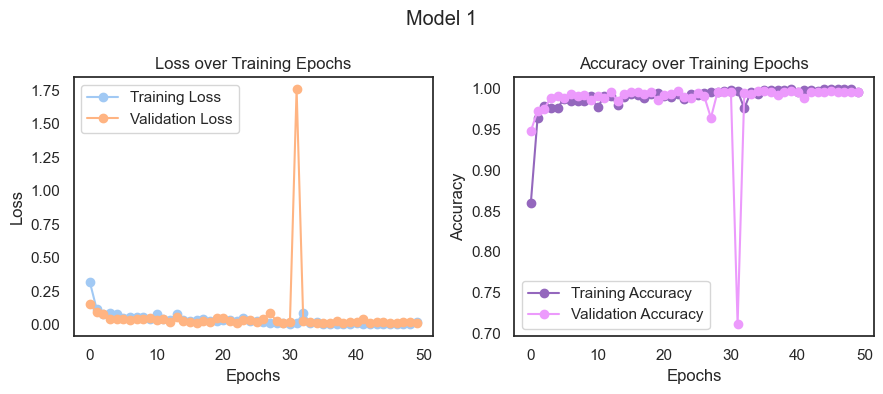

In [21]:
h = history.history

# Set Seaborn theme and style
sns.set_theme(style="white", palette="pastel")


plt.figure(figsize=(9, 4))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(h["loss"], label="Training Loss", marker="o")
plt.plot(h["val_loss"], label="Validation Loss", marker="o")
plt.title("Loss over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)

plt.plot(h["binary_accuracy"], label="Training Accuracy", marker="o", color="#9467bd")
plt.plot(h["val_binary_accuracy"], label="Validation Accuracy", marker="o", color="#ec9afc")
plt.title("Accuracy over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.suptitle("Model 1")

plt.tight_layout()
plt.show()

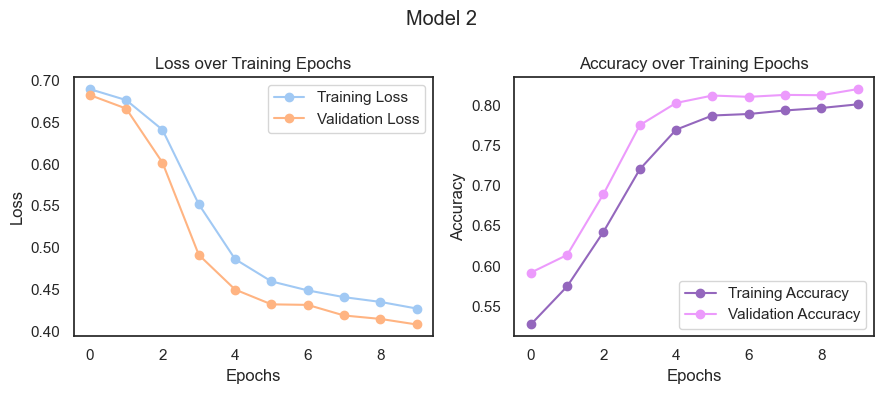

In [23]:
h2 = history_2.history

plt.figure(figsize=(9, 4))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(h2["loss"], label="Training Loss", marker="o")
plt.plot(h2["val_loss"], label="Validation Loss", marker="o")
plt.title("Loss over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)

plt.plot(h2["binary_accuracy"], label="Training Accuracy", marker="o", color="#9467bd")
plt.plot(h2["val_binary_accuracy"], label="Validation Accuracy", marker="o", color="#ec9afc")
plt.title("Accuracy over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.suptitle("Model 2")

plt.tight_layout()
plt.show()

In [24]:
def plot_confusion_matrix(
    actual_labels, predicted_labels, labels, title="Confusion Matrix"
):
    cm = confusion_matrix(actual_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

79/79 [==============================] - 1s 4ms/step


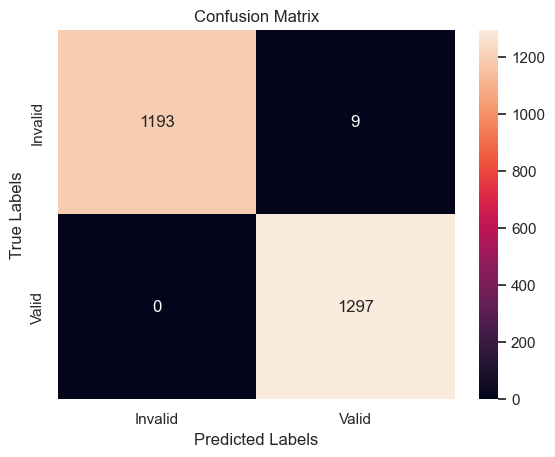

79/79 [==============================] - 0s 2ms/step


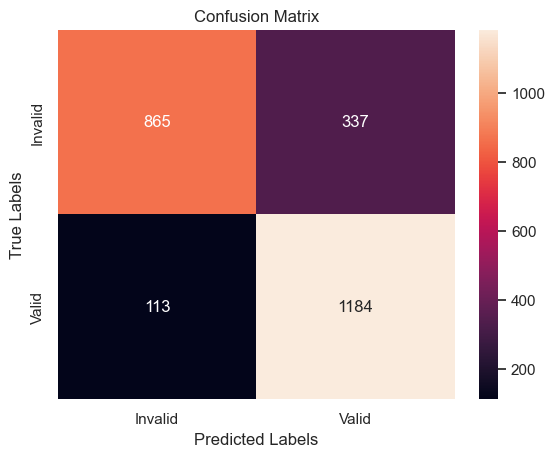

In [25]:
# plot the confusion matrix on the test data
y_pred_1 = model_1.predict(X_test)
y_pred_1 = np.round(y_pred_1).astype(int).reshape(-1)
plot_confusion_matrix(y_test, y_pred_1, labels=["Invalid", "Valid"])

# plot the confusion matrix on the test data for the second model
y_pred_2 = model_2.predict(X_test)
y_pred_2 = np.round(y_pred_2).astype(int).reshape(-1)
plot_confusion_matrix(y_test, y_pred_2, labels=["Invalid", "Valid"])

In [26]:
sample_test_data = pd.DataFrame(
    np.concatenate([X_test[:10], y_test[:10].reshape(-1, 1)], axis=1),
)
sample_test_data

,0,1,2,3,4,5,6,7,8
0,3,4,5,6,0,0,0,0,1
1,1,5,1,1,2,2,6,2,1
2,6,1,1,4,3,4,3,5,0
3,1,4,1,4,0,0,0,0,0
4,1,5,5,6,6,2,0,0,1
5,5,4,6,3,6,1,1,3,0
6,1,2,3,4,0,0,0,0,1
7,4,4,1,6,3,2,0,0,0
8,4,6,5,5,0,0,0,0,0
9,5,6,3,4,0,0,0,0,1


In [28]:
X_sample_decoded = np.array([decode(x) for x in X_test[:10]])
sample_test_data = pd.DataFrame(X_sample_decoded, columns=["string"])
sample_test_data["is_valid"] = y_test[:10]
sample_test_data["predicted"] = y_pred_1[:10]
sample_test_data

,string,is_valid,predicted
0,[]{},1,1
1,({(())}),1,1
2,}((][][{,0,0
3,(](],0,0
4,({{}}),1,1
5,{]}[}(([,0,0
6,()[],1,1
7,]](}[),0,0
8,]}{{,0,0
9,{}[],1,1
